<a href="https://colab.research.google.com/github/koichiromasa/scsc-interface-kinetics/blob/main/crystal_brightness_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Google Drive のマウント ライブラリのインポート

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import cv2
import cupy as cp
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import multiprocessing



2. 設定（入力・出力フォルダ

In [ ]:
input_images_dir = "/content/drive/My Drive/Colab Notebooks/result_data/POM_movie/25_120"
output_base_dir = "/content/drive/My Drive/Colab Notebooks/result_data/crystal_brightness_analysis"
video_name = os.path.basename(input_images_dir)

output_frames_dir = input_images_dir
output_dir = os.path.join(output_base_dir, video_name)
os.makedirs(output_dir, exist_ok=True)

print(f"✅ 入力画像フォルダ: {input_images_dir}")
print(f"✅ 出力フォルダ: {output_dir}")


✅ 入力画像フォルダ: /content/drive/My Drive/Colab Notebooks/result_data/POM_movie/25_120
✅ 出力フォルダ: /content/drive/My Drive/Colab Notebooks/result_data/crystal_brightness_analysis/25_120


3. フレーム情報の取得

In [ ]:
frame_files = sorted(glob.glob(os.path.join(output_frames_dir, "*.png")))
print(f"✅ 解析対象のフレーム数: {len(frame_files)} 枚")


✅ 解析対象のフレーム数: 17433 枚


4. 動き補正（光学フロー）

In [ ]:
def stabilize_frames(frames):
    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    prev_gray = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
    stabilized_frames = [frames[0]]

    for i in range(1, len(frames)):
        curr_gray = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        p0 = cv2.goodFeaturesToTrack(prev_gray, maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

        if p0 is not None:
            p1, st, _ = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, p0, None, **lk_params)
            if p1 is not None and st.sum() > 0:
                dx = np.median(p1[:, 0, 0] - p0[:, 0, 0])
                dy = np.median(p1[:, 0, 1] - p0[:, 0, 1])
                M = np.float32([[1, 0, -dx], [0, 1, -dy]])
                stabilized_frame = cv2.warpAffine(frames[i], M, (frames[i].shape[1], frames[i].shape[0]))
            else:
                stabilized_frame = frames[i]
        else:
            stabilized_frame = frames[i]

        stabilized_frames.append(stabilized_frame)
        prev_gray = curr_gray

    return stabilized_frames


5. 小さな結晶を除去する関数

In [ ]:
def remove_small_crystals(mask, min_size=500):
    """
    小さな結晶領域を除去する関数
    mask: 二値化画像
    min_size: 除去する結晶の最小サイズ（ピクセル）
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_mask = np.zeros_like(mask)  # 初期化
    for contour in contours:
        if cv2.contourArea(contour) >= min_size:
            cv2.drawContours(filtered_mask, [contour], -1, 255, thickness=cv2.FILLED)  # 小さな領域を削除
    return filtered_mask


6. 適応的閾値処理（CLAHE + Otsuの二値化 + 小結晶除去）

In [ ]:
def adaptive_threshold_gpu(img):
    gray_gpu = cp.asarray(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))  # 画像をグレースケールに変換 (GPU)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # CLAHE（ヒストグラム均等化）適用
    enhanced_gpu = cp.asarray(clahe.apply(cp.asnumpy(gray_gpu)))

    # Otsuの閾値処理 (2値化)
    _, thresholded_gpu = cv2.threshold(cp.asnumpy(enhanced_gpu), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresholded_cpu = cp.asnumpy(thresholded_gpu)  # CPU に戻す

    # 小さな結晶を除去（ノイズを削除）
    thresholded_cpu = remove_small_crystals(thresholded_cpu, min_size=500)

    return thresholded_cpu  # CPU に戻した結果を返す


7. 画像をランダムに10枚表示（閾値処理前後）

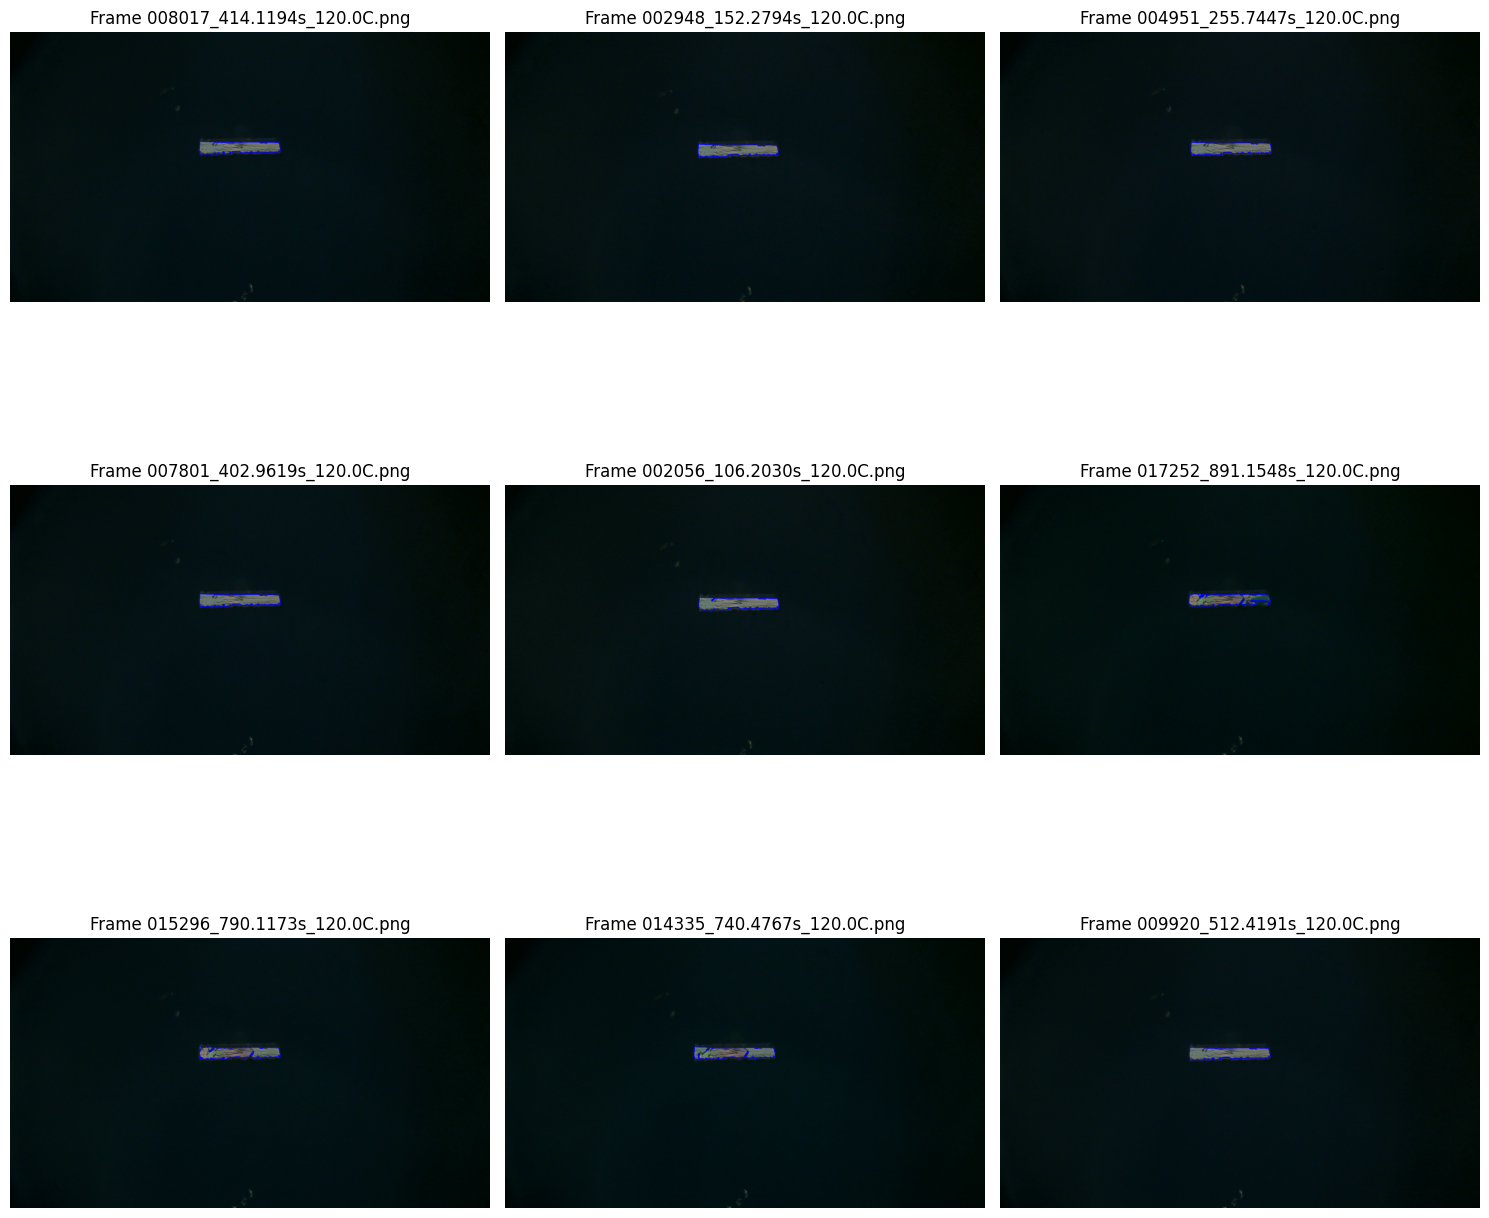

In [ ]:
def draw_contours(img, mask):
    """
    閾値処理後のマスク画像に対して、結晶の輪郭を赤色で描画
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_contours = img.copy()
    cv2.drawContours(img_contours, contours, -1, (0, 0, 255), 2)  # 赤色で輪郭を描画
    return img_contours

def display_random_images():
    """
    ランダムに 9 枚の画像を選択し、閾値処理後の結果を 3×3 グリッドで表示
    """
    random_files = random.sample(frame_files, min(9, len(frame_files)))  # 最大9枚選択
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3×3のグリッドで表示

    for ax, frame_file in zip(axes.flatten(), random_files):
        img = cv2.imread(frame_file)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = adaptive_threshold_gpu(img)
        img_with_contours = draw_contours(img_rgb, mask)

        ax.imshow(img_with_contours)
        ax.set_title(f"Frame {os.path.basename(frame_file)}")  # 画像番号を表示
        ax.axis("off")

    plt.tight_layout()  # 余白を最適化
    plt.show()

display_random_images()


8. 全フレームを解析

In [ ]:
import concurrent.futures  # 追加
import os  # os.cpu_count() を使うため追加

def process_frame(frame_file):
    """ 各フレームの結晶内部の輝度を解析 """
    img = cv2.imread(frame_file, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = adaptive_threshold_gpu(img)

    # 結晶領域を抽出
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:  # 結晶領域がない場合はスキップ
        return (None, None, 0)

    mask_cleaned = np.zeros_like(mask)
    cv2.drawContours(mask_cleaned, contours, -1, 255, thickness=cv2.FILLED)  # 結晶内部を白にする

    # ノイズ除去（小さな誤認識を削除）
    kernel = np.ones((3,3), np.uint8)
    mask_cleaned = cv2.erode(mask_cleaned, kernel, iterations=1)

    # 結晶内部の輝度を計算
    brightness = cp.mean(cp.array(gray)[mask_cleaned > 0]).get() if np.any(mask_cleaned > 0) else 0

    # フレーム名から時間と温度を抽出
    try:
        frame_name = os.path.basename(frame_file).split("_")
        time_sec = float(frame_name[1].replace("s", ""))
        temp_c = float(frame_name[2].replace("C.png", ""))
    except ValueError:
        time_sec, temp_c = None, None

    return (time_sec, temp_c, brightness)

def analyze_all_frames_parallel():
    """ 全フレームを並列処理し、解析結果を保存 """
    brightness_data = []

    # マルチスレッドで処理
    with concurrent.futures.ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        results = list(tqdm(executor.map(process_frame, frame_files), total=len(frame_files)))

    brightness_data.extend(results)

    # DataFrame に変換
    df = pd.DataFrame(brightness_data, columns=["Time (s)", "Temperature (°C)", "Brightness"])
    output_csv_path = os.path.join(output_dir, "crystal_brightness_data.csv")
    df.to_csv(output_csv_path, index=False)

    print(f"✅ 解析データを保存しました: {output_csv_path}")
    return df

df = analyze_all_frames_parallel()


NameError: name 'tqdm' is not defined

9. グラフの描画と保存

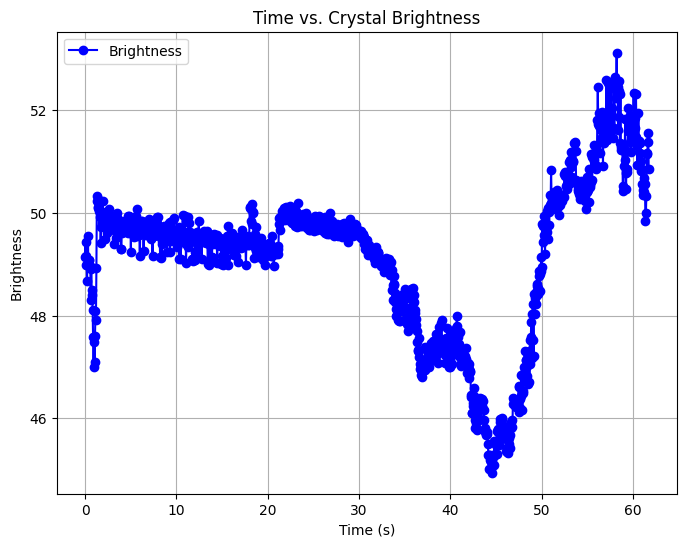

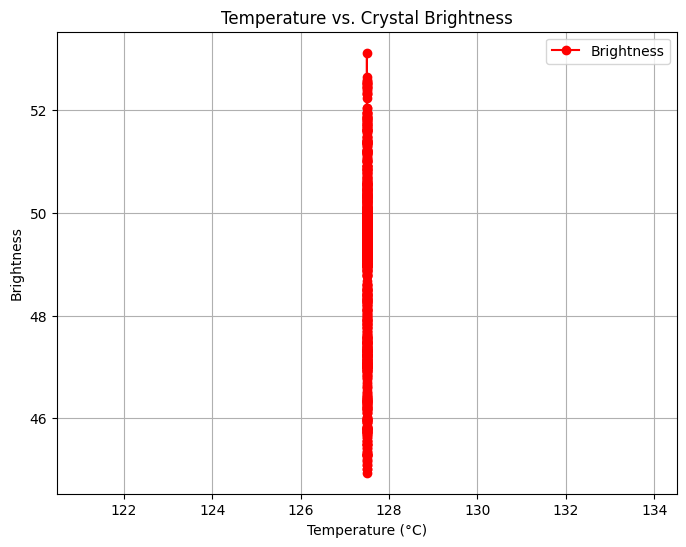

In [ ]:
def plot_and_save_graphs(df):
    plt.figure(figsize=(8, 6))
    plt.plot(df["Time (s)"], df["Brightness"], marker='o', linestyle='-', color='blue', label='Brightness')
    plt.xlabel("Time (s)")
    plt.ylabel("Brightness")
    plt.title("Time vs. Crystal Brightness")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "brightness_vs_time.png"))
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(df["Temperature (°C)"], df["Brightness"], marker='o', linestyle='-', color='red', label='Brightness')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Brightness")
    plt.title("Temperature vs. Crystal Brightness")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "brightness_vs_temperature.png"))
    plt.show()

plot_and_save_graphs(df)
